### iButton data prep and analysis framework
We need a set of code to quickly parse and download data collected from iButtons. Ultimately the functionality in this notebook will be packaged into a standalone set of functions that will be able to be applied in a batch context.

The general strategy will be to create a dict for each iButton downloaded. The dictionary will contain a field for each unique attribute that the iButton holds -- for example, an entry for Serial Number will hold a string for that unit, and an entry for Measurements will hold a pandas dataframe of the data for that particular file.

Initially, I plan to provide functionality to concatenate the data by sensor or location, and to export a sort of masterlist of measurement data.

In [30]:
# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import os, csv, fnmatch
import datetime
from pandas.tseries.offsets import *

dataDir = 'W:/iButton_Data/temp_unk'

In [10]:
# Create a list of all of the iButton data files in the data directory
# returns fully qualified list of all csv files in the specified directory
def genDataList(dataDir):    
    fileNames = []
    for root, dirnames, filenames in os.walk(dataDir):
        for filename in fnmatch.filter(filenames, '*.csv'):
            fileNames.append(os.path.join(root, filename))
    return fileNames

# Create a pandas dataframe from the CSV reader object
# returns: pandas DF of TA and rH, with full posix timestamps
def genDF(rawiButtonCSV, csvAsList):
    
        # First we convert the entire CSV into a numpy array
        iButtonAsArray = np.array(csvAsList)
        
        # We need to determine where the timestamp starts so we can include
        # the the apropriate data in the measurements DF. Probably a better
        # way to handle this...
        for xx in np.arange(4,10):
            if iButtonAsArray[xx][0] == 'Date - Time':
                meas =  xx + 1
                
        dataArray = np.array(csvAsList[meas:len(csvAsList)-1])
        
        try:
            measurementsDF = pd.DataFrame(dataArray, 
                            columns = ['tstamps','Temp','rH'])      
        except:
            measurementsDF = pd.DataFrame(dataArray, 
                            columns = ['tstamps'])         
            notice1 = 'Error assigning data columns in: '
            notice2 = 'Assigning data to -9999...'
            print(notice1, ibuttonPath)
            print(notice2)
            measurementsDF['Temp'] = -9999
            measurementsDF['rH'] = -9999
            
        try: 
            measurementsDF.index=pd.to_datetime(measurementsDF.tstamps)           
        except:
            measurementsDF.index=pd.to_datetime(measurementsDF.tstamps, unit = 'D') - DateOffset(years = 70)
            notice = 'Converting JulianDay to YYYY-MM-DD for: '
            print(notice, ibuttonPath)         
             
        measurementsDF['Temp'] = measurementsDF['Temp'].astype(float)
        measurementsDF['rH'] = measurementsDF['rH'].astype(float)
        return measurementsDF.drop('tstamps',axis = 1)

# Create a dictionary for an iButton data file, composed of sensor and location 
# metadata and measurements
# returns: single dictionary containing keys for all metadata and measurements
def genSensorDict(rawiButtonCSV):
    
    # Open the CSV file
    with open(rawiButtonCSV, 'rt', encoding='cp1252') as csvfile:
        thisiButton = csv.reader(csvfile)
        ibuttonlist = list(thisiButton)
        
        # Build a dictionary with the metadata
        ibutton = {'Ownership' :     ibuttonlist[0][0]}
        ibutton['Date Downloaded'] = ibuttonlist[0][1]
        ibutton['Serial Number']   = ibuttonlist[3][1]
        locationString             = ibuttonlist[4][1]
        
        # Some of the Shrub plots are labeled as 'Covered' before 2018
        # Here we fix that inconsistency while we read in the data
        locationString = locationString.replace('Covered','Shrub')
        ibutton['Location']        = locationString
        
        # Finally we include a PandasDF for the temp and rH data
        # with timestamps
        ibutton['Measurements']    = genDF(rawiButtonCSV, ibuttonlist)
    return ibutton

def locSearch(location, ibuttonList):
    queriedDicts = [ibutton for ibutton in ibuttonList if ibutton['Location'] == location]

    for idx in np.arange(0,len(queriedDicts)):
        if idx == 0:
            queriedMeasurements = queriedDicts[0]['Measurements']
            #queriedLocations    = queriedDicts[0]['Location']
        if idx > 0:
            queriedMeasurements = pd.concat([queriedMeasurements, queriedDicts[idx]['Measurements']])
            #queriedLocations.append[queriedDicts[idx]['Location']]
        #uniqueLocations = np.unique(queriedLocations)
        
    return queriedMeasurements

### Basic Workflow
#### Iterate over all iButton data files
These can be placed inside of directories associated with their download date, or by site -- however the organization of the raw data, all of the metadata that discerns one iButton from another is listed in the data file. The file name contains both the date that the data was downloaded and the serial number of the iButton -- we leverage this in the dictionary creation to keep things organized. 

During this file iteration process we build a list of dictionaries, where each dictionary corresponds to a single iButton download file. This means that in order to look at the data for a single point in space over time, we may need to have a way to query the data for multiple dictionary entries at a time.

#### Create a dictionary for each iButton
These dictionaries each contain keys for metadata and measurements, including the plot name, latitude and longitude, serial number of the specific iButton that corresponds to that measurement window, and the raw data in the form of a Pandas dataframe. 

#### Store each dictionary as an element in a list

In [11]:
#Create a blank list in which to store the ibutton data.
ibuttonData = []

# Create a blank dictionary to associate list entries with various attributes
metadata = {}

# Generate the list of files associated with the ibutton data.
ibuttonFilesList = genDataList(dataDir)

idx = 0
# Create a list of dicts, one dict entry for each ibutton file
for ibuttonPath in ibuttonFilesList:
    # TO DO # Output data range information and number of files read
    # print(ibuttonPath)
    
    sensorIDX = genSensorDict(ibuttonPath)
    ibuttonData.append(sensorIDX)
    idx += 1
    
allLocations = []

for iButton in ibuttonData:
    allLocations.append(iButton['Location'])
totalLocationNames = np.unique(allLocations)


Converting JulianDay to YYYY-MM-DD for:  W:/iButton_Data/temp_unk\0509-2017\D50000003F167741_170509_1NO.csv
Converting JulianDay to YYYY-MM-DD for:  W:/iButton_Data/temp_unk\0509-2017\D2000000456C2A41_170509.csv
Converting JulianDay to YYYY-MM-DD for:  W:/iButton_Data/temp_unk\0509-2017\2F0000003F18F141_170509.csv
Converting JulianDay to YYYY-MM-DD for:  W:/iButton_Data/temp_unk\0509-2017\430000003F0D1441_170509.csv
Converting JulianDay to YYYY-MM-DD for:  W:/iButton_Data/temp_unk\0509-2017\32000000456FDE41_170509.csv
Converting JulianDay to YYYY-MM-DD for:  W:/iButton_Data/temp_unk\0509-2017\CD0000003F024E41_170509.csv
Converting JulianDay to YYYY-MM-DD for:  W:/iButton_Data/temp_unk\0509-2017\1A0000003F00A241_170509.csv
Converting JulianDay to YYYY-MM-DD for:  W:/iButton_Data/temp_unk\0509-2017\070000003F04B141_170509.csv
Converting JulianDay to YYYY-MM-DD for:  W:/iButton_Data/temp_unk\0509-2017\200000003F15B841_170509.csv
Converting JulianDay to YYYY-MM-DD for:  W:/iButton_Data/tem

## Generating descriptive reports from the list of dictionaries
This way we can accomplish a variety of tasks fairly quickly -- for instance, we can produce  a QA overview that lists each iButton serial number, as well as its plot and cover combination, and associate it with some descriptive statistics for that particular dictionary entry. 

In [48]:
DOWNLOAD_DATE = []
TEMP_MAX = []
TEMP_MIN = []
RH_MAX = []
RH_MIN = [] 
SERIAL = []
ASPECT = []
COVER  = []
PLOT   = []
TA_FLAG = []
RH_FLAG   = []

for iButton in ibuttonData:
    # This is the haneous logic we can remove when the iButton files are grouped correctly
    if (len(iButton['Location'].split('_')) == 4) & ('test' not in iButton['Location']) \
        & ('PJ' not in iButton['Location']):
        plotNum    = iButton['Location'].split('_')[1]
        plotAspect = iButton['Location'].split('_')[2]
        plotCover  = iButton['Location'].split('_')[3]
        
        DOWNLOAD_DATE.append(iButton['Date Downloaded'])        
        TEMP_MAX.append(iButton['Measurements'].Temp.max())
        TEMP_MIN.append(iButton['Measurements'].Temp.min())
        RH_MAX.append(iButton['Measurements'].rH.max())
        RH_MIN.append(iButton['Measurements'].rH.min())
        SERIAL.append(iButton['Serial Number'])
        ASPECT.append(plotAspect)
        COVER.append(plotCover)
        PLOT.append(plotNum)
        
        if iButton['Measurements'].Temp.max() > 70:
            TA_FLAG.append(1)
        else:
            TA_FLAG.append(0)
        if iButton['Measurements'].rH.min() < 0:
            RH_FLAG.append(1)
        else:
            RH_FLAG.append(0)

        
QA_list = pd.DataFrame(dict(Date = DOWNLOAD_DATE, TA_Max = TEMP_MAX, TA_Min = TEMP_MIN,
                  rH_Max = RH_MAX, rH_Min = RH_MIN, SerialNum = SERIAL, Aspect = ASPECT,
                  Cover = COVER, Plot = PLOT, TA_Flag = TA_FLAG, rH_Flag = RH_FLAG))

sortedQA = QA_list[['Date','SerialNum','Plot','Aspect','Cover','TA_Max',
                    'TA_Min','rH_Max','rH_Min', 'TA_Flag', 'rH_Flag']]

todaysDate = str(datetime.datetime.now()).split(' ')[0]
sortedQA.to_csv('iButton_QA_' + todaysDate + '.csv', index=False)

### Now we can query our list of iButton data
and generate summary time series, or ask other questions about the collection of data. We want some generic summarizing that will gather time series for each individual plot / cover combination, as well as some summary descriptions by plot or by cover. We can handle this a couple ways, I think the most parsimonious is to just create a master list of sorts that we can continue to update. We can parse the cover types and plot numbers from the location field to add as attributes to our data frame and run everything in Pandas.

We need to filter out the iButtons we actually want to include here -- and this is sort of a temporary fix. There are a bunch of files that were from the pilot test for instance, with names like 'RS2650a', or some that were temporary Vexar tests for instance. This wouldn't be necessary to handle if we had the data organized prior to running the code... but in the interest of time, I'll only accept location codes that follow the standard 'Plot_Num_Aspect_Cover' format.

In [12]:
idx = 0
for iButton in ibuttonData:
    # This is the haneous logic we can remove when the iButton files are grouped correctly
    if (len(iButton['Location'].split('_')) == 4) & ('test' not in iButton['Location']) \
        & ('PJ' not in iButton['Location']):
        plotNum    = iButton['Location'].split('_')[1]
        plotAspect = iButton['Location'].split('_')[2]
        plotCover  = iButton['Location'].split('_')[3]

        if idx == 0:
            all_iButtonDF = pd.DataFrame(dict(TS = iButton['Measurements'].index,
                                          YEAR   = iButton['Measurements'].index.year,
                                          MONTH  = iButton['Measurements'].index.month,
                                          DOY    = iButton['Measurements'].index.dayofyear,
                                          TEMP   = iButton['Measurements'].Temp,
                                          RH     = iButton['Measurements'].rH,
                                          SERIAL = iButton['Serial Number'],
                                          PLOT   = plotNum,
                                          ASPECT = plotAspect,
                                          COVER  = plotCover))
            idx += 1
        else:
            iButtonDF = pd.DataFrame(dict(TS = iButton['Measurements'].index,
                                      YEAR   = iButton['Measurements'].index.year,
                                      MONTH  = iButton['Measurements'].index.month,
                                      DOY    = iButton['Measurements'].index.dayofyear,
                                      TEMP   = iButton['Measurements'].Temp,
                                      RH     = iButton['Measurements'].rH,
                                      SERIAL = iButton['Serial Number'],
                                      PLOT   = plotNum,
                                      ASPECT = plotAspect,
                                      COVER  = plotCover))
            all_iButtonDF = pd.concat([all_iButtonDF,iButtonDF])
            
            idx += 1

### This makes us one large dataframe that we can cut up
really however we want. For now this seems like enough, we can create some quick and dirty summary plots later on, maybe some QA functionality in the future as well. Let's take a quick look at the data and make sure the format looks OK

In [14]:
all_iButtonDF.head()

,TS,YEAR,MONTH,DOY,TEMP,RH,SERIAL,PLOT,ASPECT,COVER
tstamps,,,,,,,,,,
2018-05-15 08:41:01,2018-05-15 08:41:01,2018,5,135,29.6,17.9,E60000003F0B6C41,1,South,Shrub
2018-05-15 09:11:01,2018-05-15 09:11:01,2018,5,135,27.6,11.6,E60000003F0B6C41,1,South,Shrub
2018-05-15 09:41:01,2018-05-15 09:41:01,2018,5,135,27.6,10.2,E60000003F0B6C41,1,South,Shrub
2018-05-15 10:11:01,2018-05-15 10:11:01,2018,5,135,29.1,10.2,E60000003F0B6C41,1,South,Shrub
2018-05-15 10:41:01,2018-05-15 10:41:01,2018,5,135,29.1,11.6,E60000003F0B6C41,1,South,Shrub


### Seems reasonable enough
We can create a couple quick time series plots as well -- say for instance we want to visualize time series with some sort of smoothed mean for Plot 4. With the data in this format we have a lot of flexibility with respect to how we decide to plot things.

C:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


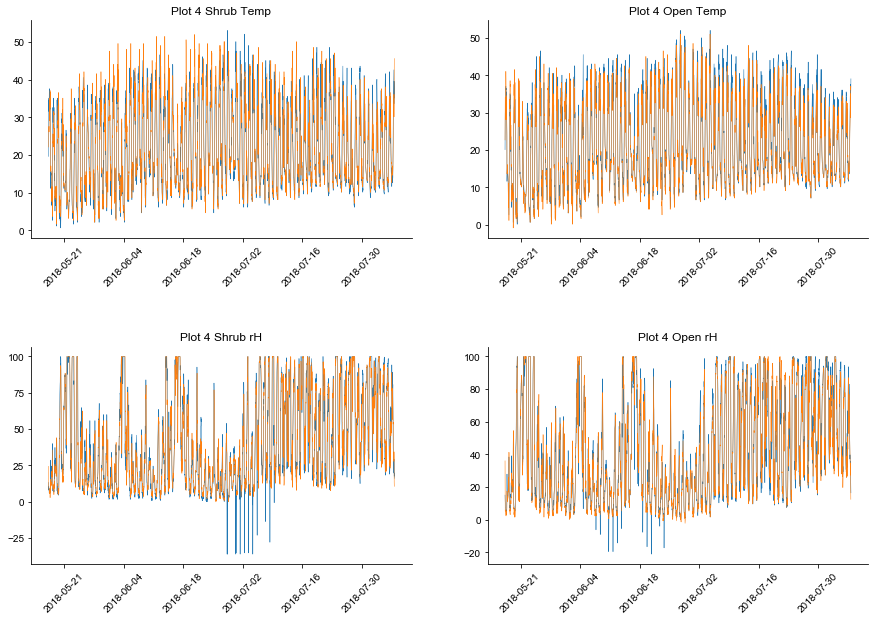

In [15]:
plot4 = all_iButtonDF[(all_iButtonDF.PLOT == '4') & (all_iButtonDF.YEAR == 2018)]
plot4S = plot4[plot4.COVER == 'Shrub']
plot4S.sort_values('TS', inplace=True)

plot4O = plot4[plot4.COVER == 'Open']
plot4O.sort_values('TS', inplace=True)


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15,10))
plt.subplots_adjust(hspace = 0.5)
ax1.plot(plot4S[plot4S.ASPECT == 'North'].TEMP, lw = 0.5)
ax1.plot(plot4S[plot4S.ASPECT == 'South'].TEMP, lw = 0.5)

ax2.plot(plot4O[plot4O.ASPECT == 'North'].TEMP, lw = 0.5)
ax2.plot(plot4O[plot4O.ASPECT == 'South'].TEMP, lw = 0.5)

ax3.plot(plot4S[plot4S.ASPECT == 'North'].RH, lw = 0.5)
ax3.plot(plot4S[plot4S.ASPECT == 'South'].RH, lw = 0.5)

ax4.plot(plot4O[plot4O.ASPECT == 'North'].RH, lw = 0.5)
ax4.plot(plot4O[plot4O.ASPECT == 'South'].RH, lw = 0.5)


axs = f.axes

ax1.set_title('Plot 4 Shrub Temp')
ax2.set_title('Plot 4 Open Temp')
ax3.set_title('Plot 4 Shrub rH')
ax4.set_title('Plot 4 Open rH')

for ax in axs:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.5)


### We can also quickly generate summary statistics by plot
or cover, or maybe to look at min and max values by month for instance

In [16]:
# As an example ...
all_iButtonDF.groupby(['YEAR','MONTH','PLOT','ASPECT','COVER']).TEMP.describe().head()

count       mean       std  min    25%   50%  \
YEAR MONTH PLOT ASPECT COVER                                                  
2017 4     1    North  Open   2170.0  10.866129  9.853394 -5.5  2.500  8.50   
                       Shrub  2168.0  10.696725  9.844988 -5.0  3.000  8.50   
                South  Open   2168.0  10.756596  9.968260 -6.5  2.875  9.10   
                       Shrub  2170.0  10.905806  9.625687 -6.0  3.100  9.10   
           10   North  Open   3348.0   9.681213  9.650058 -9.0  2.100  7.85   

                               75%   max  
YEAR MONTH PLOT ASPECT COVER              
2017 4     1    North  Open   20.0  33.5  
                       Shrub  19.5  33.5  
                South  Open   18.6  36.1  
                       Shrub  18.6  37.1  
           10   North  Open   17.6  32.1

### What about plots that have had multiple iButtons?
Certainly there have been times when we have had to replace ibuttons in a plot, either because they went missing, were unable to be downloaded, or were completely destroyed. Sensor continuity is an interesting question, and has some statistical implications -- we can quickly look for plots that have multiple unique iButton serial numbers, and capture then plot those data. Here is an example. 

['10', 'South', 'Open']


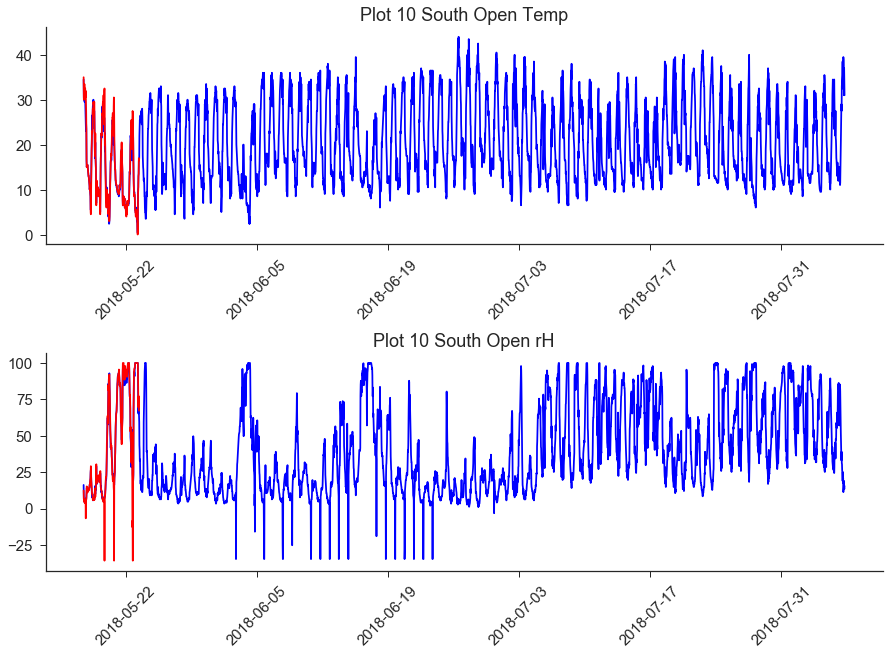

In [17]:
for plot in np.unique(all_iButtonDF['PLOT']):
    thisPlot = all_iButtonDF[all_iButtonDF['PLOT'] == plot]
    for aspect in ['North','South']:
        thisAspect = thisPlot[thisPlot['ASPECT'] == aspect]
        for cover in ['Shrub','Open']:
            thisCover = thisAspect[thisAspect['COVER'] == cover]
            if len(np.unique(thisCover.SERIAL)) > 2:
                toPlot = thisCover.sort_index()
                print([plot, aspect, cover])

colors = ['blue','red','black','gray']                
f, ((ax1, ax2)) = plt.subplots(2,1, figsize = (15,10))
plt.subplots_adjust(hspace = 0.5)

idx = 0
for serial in np.unique(toPlot.SERIAL):
    thisSerial = toPlot[(toPlot.YEAR == 2018) & (toPlot.SERIAL == serial)]
    ax1.plot(thisSerial.TEMP, color = colors[idx])
    ax2.plot(thisSerial.RH, color = colors[idx])

    idx += 1

axs = f.axes

ax1.set_title('Plot 10 South Open Temp')
ax2.set_title('Plot 10 South Open rH')

for ax in axs:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.5)


### We can see from the above graph
that something wonky is going on with plot 10 South Open data. It appears there might be a naming mismatch in the first download of 2018 or something, because we shouldn't have overlap in time and space for two different sensors, unless someone was specifically testing how they compare. In any case, here is the foundation for quickly cutting up these data so that we can ask questions about a specific sensor, a specific plot, or generate summary statistics on groups of sensors quickly.

In [44]:
all_iButtonDF.head()

,TS,YEAR,MONTH,DOY,TEMP,RH,SERIAL,PLOT,ASPECT,COVER
tstamps,,,,,,,,,,
2018-05-15 08:41:01,2018-05-15 08:41:01,2018,5,135,29.6,17.9,E60000003F0B6C41,1,South,Shrub
2018-05-15 09:11:01,2018-05-15 09:11:01,2018,5,135,27.6,11.6,E60000003F0B6C41,1,South,Shrub
2018-05-15 09:41:01,2018-05-15 09:41:01,2018,5,135,27.6,10.2,E60000003F0B6C41,1,South,Shrub
2018-05-15 10:11:01,2018-05-15 10:11:01,2018,5,135,29.1,10.2,E60000003F0B6C41,1,South,Shrub
2018-05-15 10:41:01,2018-05-15 10:41:01,2018,5,135,29.1,11.6,E60000003F0B6C41,1,South,Shrub


In [49]:
all_iButtonDF_sorted = all_iButtonDF[['TS','SERIAL','YEAR','MONTH','DOY','PLOT','ASPECT','COVER','TEMP','RH']]
todaysDate = str(datetime.datetime.now()).split(' ')[0]
all_iButtonDF_sorted.to_csv('iButton_Master_' + todaysDate + '.csv', index = False)